# PCA AND CLUSTERING TECHNIQUES IN PYTHON

## PART I: Principal Component Analysis

### CODE IMPLEMENTATION

In [5]:
# Library Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from seaborn import load_dataset
# plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

Seaborn comes with a number of built-in datasets.
To get a list of all the ones that are prepackaged, use the `get_dataset_names` method.

In [6]:
print("The available datasets in Seaborn are:", end="\n")
print("*"*30, end="")
for data in sns.get_dataset_names():
    print(data)
    
print("*"*30)

The available datasets in Seaborn are:
******************************anagrams
anscombe
attention
brain_networks
car_crashes
diamonds
dots
dowjones
exercise
flights
fmri
geyser
glue
healthexp
iris
mpg
penguins
planets
seaice
taxis
tips
titanic
******************************


> For ease of simplicity when it comes to visualization, the mpg/mtcars dataset shall be used to demonstrate PCA.

We'd also like to see how the various attributes contribute to the principal components

In [7]:
# Create the mpg dataset
mpg = load_dataset(name='mpg')
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [8]:
mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


Let's do a little bit of exploration to understand what this dataset has.

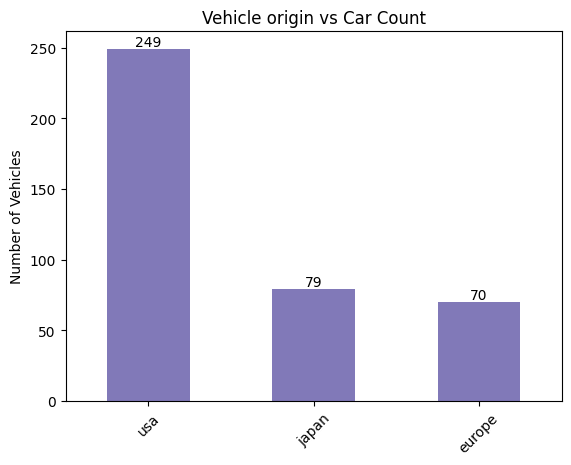

In [9]:
# How many regions does the dataset encompass?
dataLabels, countries = mpg['origin'].value_counts().values, mpg['origin'].value_counts().index

ax = mpg['origin'].value_counts().plot(kind='bar', color='#8179B8')
ax.set_title('Vehicle origin vs Car Count')
ax.set_ylabel('Number of Vehicles')
ax.set_xticklabels(labels=countries, rotation=45)
ax.bar_label(ax.containers[0]);

> I think you'd all benefit from understanding how to add bar labels so please use [this](https://stackoverflow.com/questions/28931224/how-to-add-value-labels-on-a-bar-chart#:~:text=As%20of%20matplotlib,in%20the%20list) for your reference.

In [10]:
# Any remarkable stats for vehicles manufactured in each region?

mpg.groupby(by='origin')[['cylinders', 'horsepower', 'acceleration',
                          'model_year', 'weight']].mean()

,cylinders,horsepower,acceleration,model_year,weight
origin,,,,,
europe,4.157143,80.558824,16.787143,75.814286,2423.300000
japan,4.101266,79.835443,16.172152,77.443038,2221.227848
usa,6.248996,119.048980,15.033735,75.610442,3361.931727


Deductions?

In [11]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

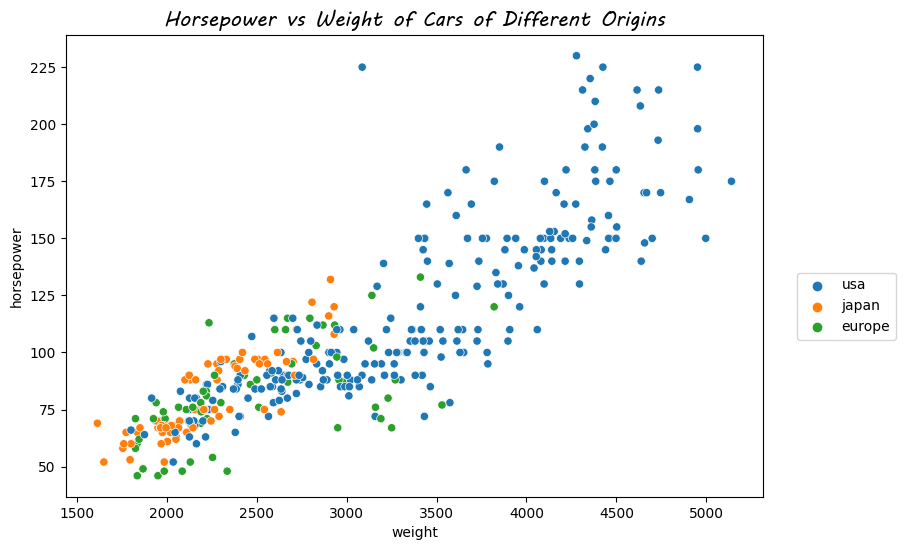

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.scatterplot(data=mpg, y='horsepower', x='weight',
                hue='origin')
ax.set_title('Horsepower vs Weight of Cars of Different Origins', fontweight='bold',
             fontsize=15, family='MV Boli')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5));

> Interpretation?

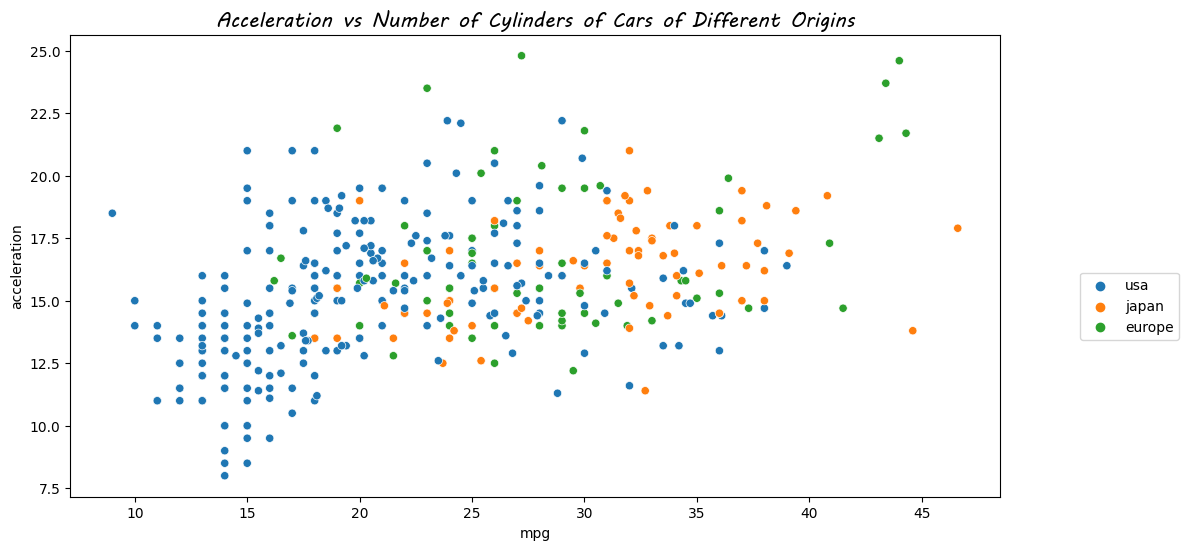

In [13]:
# Acceleration vs Cylinders
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.scatterplot(data=mpg, y='acceleration', x='mpg',
                hue='origin', marker='o', sizes=25)
ax.set_title('Acceleration vs Number of Cylinders of Cars of Different Origins',
             family='MV Boli', size=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5));

With this basic visual exploration, is it possible to have identified some common factors within the data?

For this particular dataset, we may not have a problem with the number of features. However, I think it's a great dataset to use for these unsupervised
techniques since we can introduce row labels, and also intuitively identify patterns.

In [14]:
# Check for Null Values
mpg.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [15]:
# Display the rows with null values
mpg.loc[mpg['horsepower'].isna()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


> A clever way to deal with them without affecting the data too drastically would be to impute them with regional means, i.e, 
usaHorsepowerMean and europeanHorsepowerMean.

In [36]:
# Using a smaller version of the dataset
mtcars = pd.read_csv('./mtcars.csv', index_col=0)
mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,origin
model,,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,Japan
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,Japan
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,Japan
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,USA
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,USA


In [37]:
mtcars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Mazda RX4 to Volvo 142E
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   cyl     32 non-null     int64  
 2   disp    32 non-null     float64
 3   hp      32 non-null     int64  
 4   drat    32 non-null     float64
 5   wt      32 non-null     float64
 6   qsec    32 non-null     float64
 7   vs      32 non-null     int64  
 8   am      32 non-null     int64  
 9   gear    32 non-null     int64  
 10  carb    32 non-null     int64  
 11  origin  32 non-null     object 
dtypes: float64(5), int64(6), object(1)
memory usage: 3.2+ KB


In [38]:
# Standardize the dataset
scaler = StandardScaler()
X = mtcars.drop(labels=['origin'], axis=1)
scaledX = scaler.fit_transform(X)

In [39]:
# Create Principal Components from the features
pca = PCA()

principalComponents = pca.fit_transform(scaledX)

In [40]:
# Print out a few attributes of the pca object
cumulativeVariance = np.cumsum(pca.explained_variance_ratio_)

print("The number of components produced is {}".format(pca.n_components_),
      end="\n" + "*"*30 + "\n")
print("The variance explained is as follows: \n\n{}".format(['{:.2%}'.format(x) for x in cumulativeVariance]),
      end="\n" + "*"*30 + "\n")

The number of components produced is 11
******************************
The variance explained is as follows: 

['60.08%', '84.17%', '89.87%', '92.32%', '94.36%', '96.28%', '97.51%', '98.63%', '99.33%', '99.80%', '100.00%']
******************************


From the above, it is clear even half of the principal components would be needed for any model.
However, it would be interesting to see which variables would be contributing to the first two
principal components

In [41]:
pcScores = pd.DataFrame(pca.fit_transform(X)[:, 0:2],
                        columns = ['PC1', 'PC2'], index=mtcars.index)

pcScores.head()

,PC1,PC2
model,,
Mazda RX4,-79.596425,-2.132241
Mazda RX4 Wag,-79.598570,-2.147487
Datsun 710,-133.894096,5.057570
Hornet 4 Drive,8.516559,-44.985630
Hornet Sportabout,128.686342,-30.817402


In [42]:
loadings = pd.DataFrame(pca.components_[:2].T, columns=['PC1', 'PC2'],
             index=X.columns)
loadings

,PC1,PC2
mpg,-0.038118,-0.009185
cyl,0.012035,0.003372
disp,0.899568,-0.435372
hp,0.434784,0.899307
drat,-0.002660,0.003900
wt,0.006239,-0.004861
qsec,-0.006671,-0.025012
vs,-0.002729,-0.002198
am,-0.001963,0.005794
gear,-0.002605,0.011272


In [43]:
# Data for biplot
pc1, pc2 = pca.fit_transform(X)[:, 0], pca.fit_transform(X)[:, 1]
ldngs = pca.components_

We should also define the scaling factors scalePC1 and scalePC2 to fit the data of `PC1`, `PC2` and ldngs on the same plot. Additionally, we can define the `target group names` to label the target groups in our biplots, see features below.

In [44]:
scalePC1 = 1.0/(pc1.max() - pc1.min())
scalePC2 = 1.0/(pc2.max() - pc2.min())
features = list(X.columns)

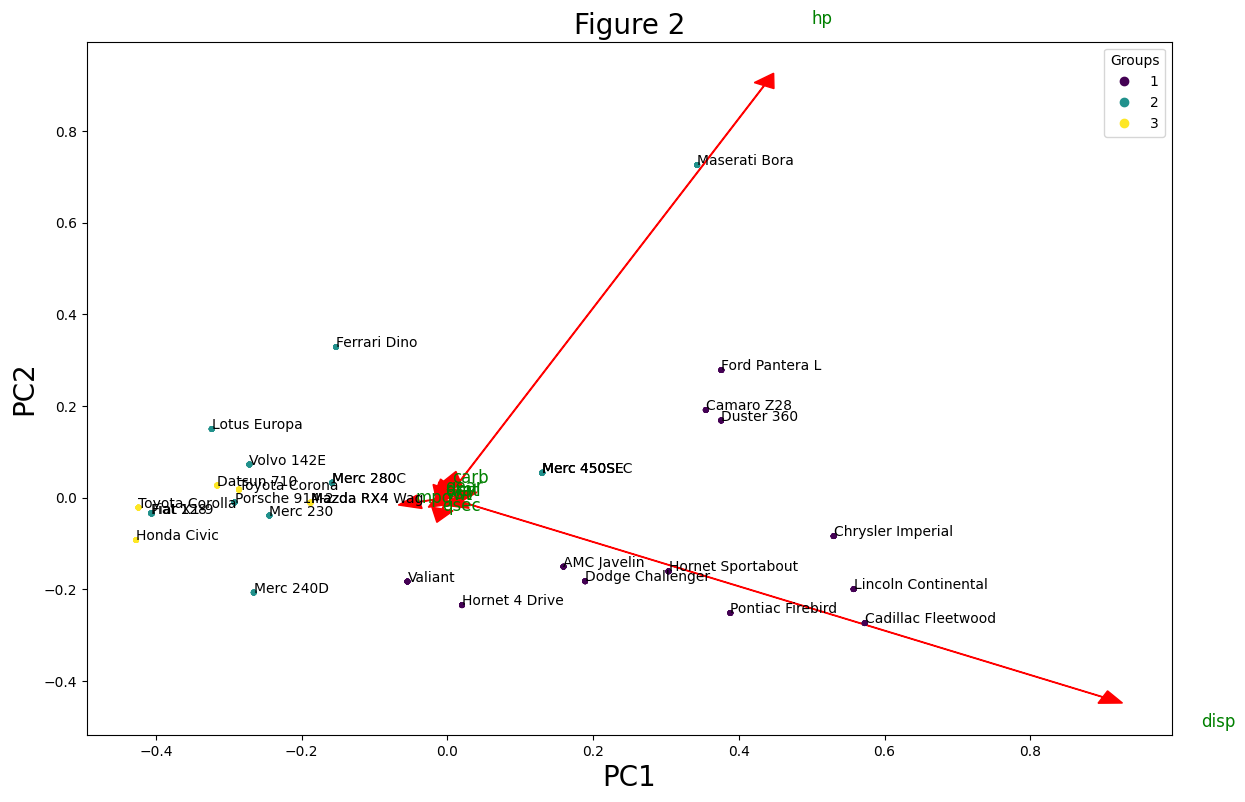

In [45]:
colorMap = {'USA': 1, 'Europe': 2, 'Japan': 3}

fig, ax = plt.subplots(figsize=(14, 9))
 
for i, feature in enumerate(features):
    ax.arrow(0, 0, ldngs[0, i], 
             ldngs[1, i], 
             head_width=0.03, 
             head_length=0.03, 
             color="red")
    ax.text(ldngs[0, i] * 1.15, 
            ldngs[1, i] * 1.15, 
            feature,color="green", fontsize=12)
 
    scatter = ax.scatter(pc1 * scalePC1,
                    pc2 * scalePC2, s=10,
                    c=mtcars['origin'].map(colorMap))
 
for i, label in enumerate(pcScores.index):
    ax.text(pc1[i] * scalePC1, 
            pc2[i] * scalePC2 , str(label), 
            fontsize=10)

ax.legend(*scatter.legend_elements(),
                    loc="upper right", 
                    title="Groups") 
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_title('Figure 2', fontsize=20);

## PART II: CLUSTERING TECHNIQUES

### HIERACHICAL CLUSTERING

In [46]:
completeClustering = linkage(scaledX, method='complete', metric='euclidean')

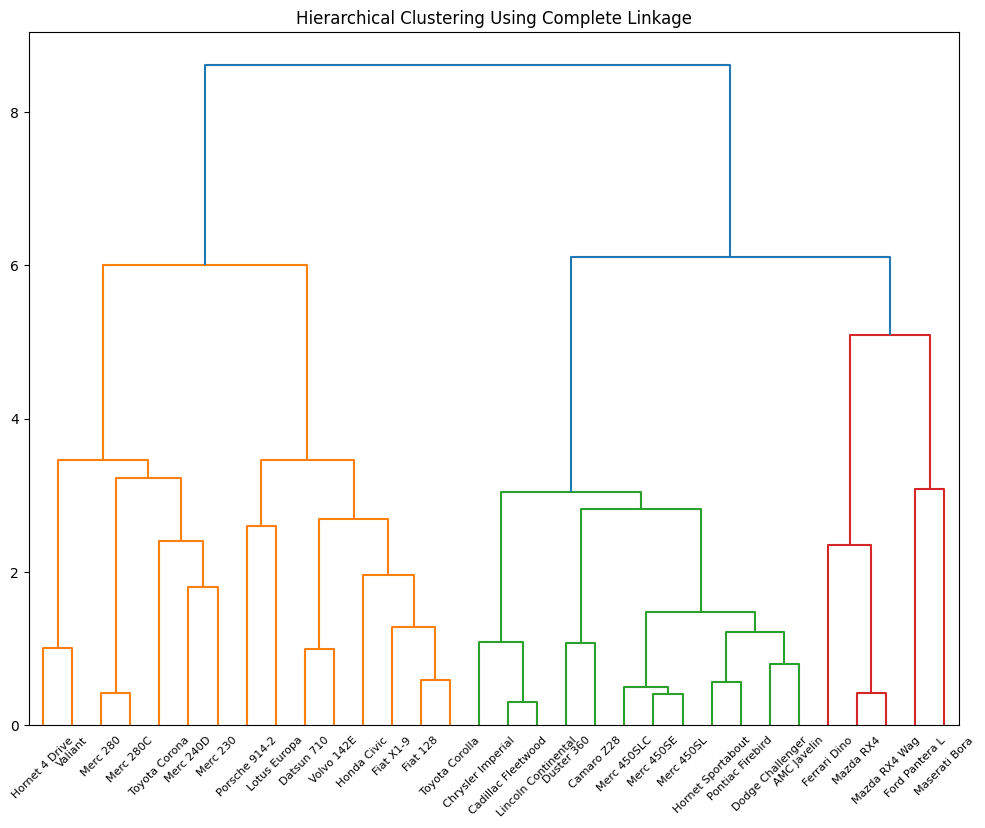

In [49]:
fig, ax = plt.subplots(figsize=(12, 9))

ax = dendrogram(completeClustering, labels=mtcars.index)
plt.title('Hierarchical Clustering Using Complete Linkage')
plt.show()

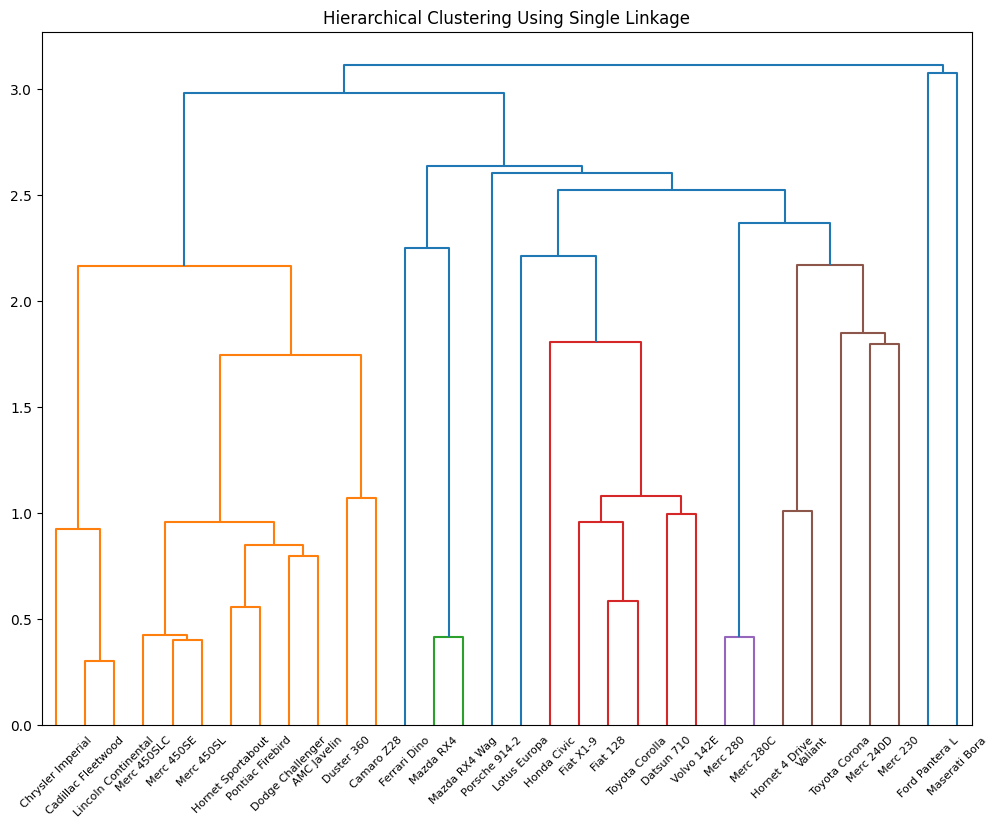

In [50]:
# Using Single Linkage
singleLinkage = linkage(scaledX, method='single', metric='euclidean')

fig, ax = plt.subplots(figsize=(12, 9))

ax = dendrogram(singleLinkage, labels=mtcars.index)
plt.title('Hierarchical Clustering Using Single Linkage')
plt.show()

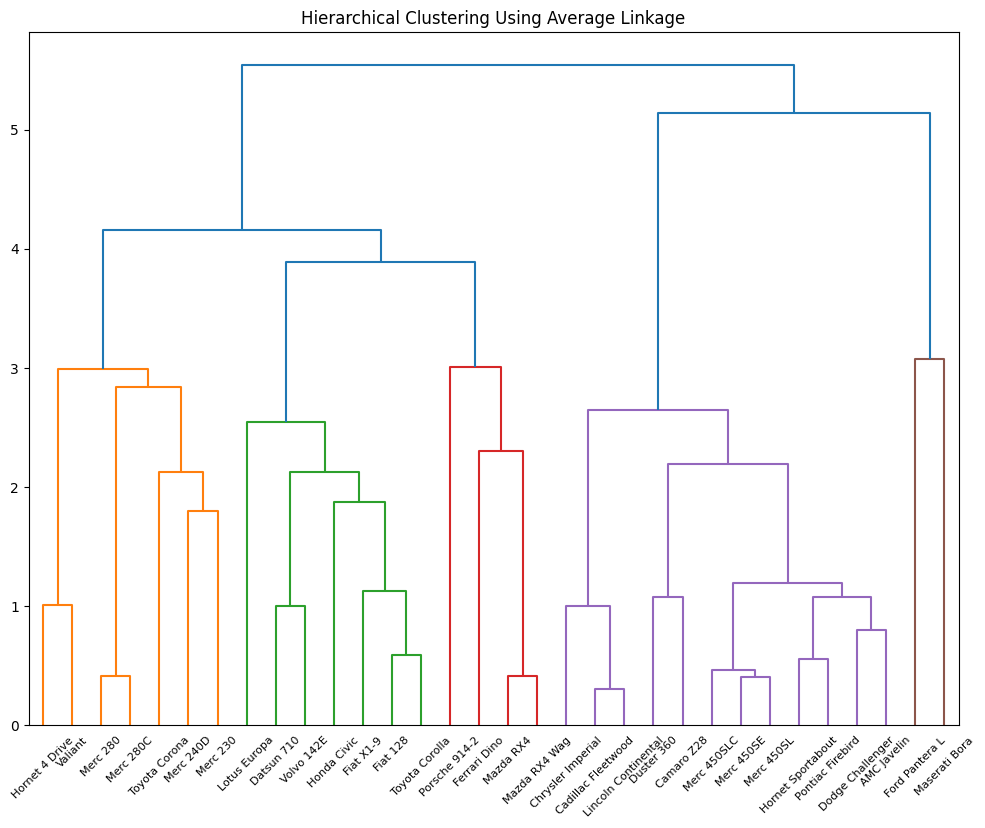

In [51]:
# Using Average Linkage Method

avgLinkage = linkage(scaledX, method='average', metric='euclidean')

fig, ax = plt.subplots(figsize=(12, 9))

ax = dendrogram(avgLinkage, labels=mtcars.index)
plt.title('Hierarchical Clustering Using Average Linkage')
plt.show()

## CONCLUSION